In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.utils import same_seed, create_Z, sample_mask, spectral_initialization
from src.nonconvex import sgd

In [2]:
def generate_data(n, m, r, mu, PSD=False, projected=False, optim='SGD', iters=100, lr=0.001, data_points=20, ensemble=10):
    # Produce Error Data
    SE, FE, GN, MEI = [], [], [], []
    probs = np.linspace(0.1, 1, data_points)
    for p in probs:
        error, loss, grad, eigen = 0, 0, 0, 0
        for i in range(ensemble):
            # Sample groundtruth and mask
            Z, mu_Z = create_Z(n, m, r, mu, PSD)
            Z = torch.tensor(Z)
            mask = sample_mask(n, m, p)
            mask = torch.tensor(mask, dtype=torch.float32)
            # Initialize optimized tensors
            L, R = spectral_initialization(p, r, Z, mask)
            L.requires_grad_(True)
            R.requires_grad_(True)
            # GD
            _losses, _error, grad_norm, min_eigen = sgd(L, R, mask, Z, mu, projected, optim, iters, lr)
            # Accumulate losses
            error += _error
            loss += _losses[-1]
            grad += grad_norm
            eigen += min_eigen
        SE.append(error / ensemble)
        FE.append(loss / ensemble)
        GN.append(grad_norm / ensemble)
        MEI.append(eigen / ensemble)
    return probs, SE, FE, GN, MEI

In [3]:
def plot_error(probs, SE, FE, GN, MEI):
    # bound = mu * r * (np.log10(n))**2 / n
    # Plotting
    fig, ax = plt.subplots(2, 2, figsize=(20, 20), tight_layout=True)
    
    ax[0][0].plot(probs, SE, marker='o', linestyle='-', color='blue', label='empirical data')
    ax[0][1].plot(probs, FE, marker='o', linestyle='-', color='blue', label='empirical data')
    ax[1][0].plot(probs, GN, marker='o', linestyle='-', color='blue', label='empirical data')
    ax[1][1].plot(probs, MEI, marker='o', linestyle='-', color='blue', label='empirical data')
    # ax.axvline(x = bound, color = 'r', label = 'theoretical bound')
    
    ax[0][0].set_xlabel("Sample Probability p", fontsize=30), 
    ax[0][0].set_ylabel(r"$\|L_tR_t^T - Z\|^2_F$", fontsize=30)
    ax[0][0].set_title(f"Impact of p on Solution Exactness", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].set_yscale('log')
    ax[0][0].grid()

    ax[0][1].set_xlabel("Sample Probability p", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(L_t, R_t)$", fontsize=30)
    ax[0][1].set_title(f"Impact of p on Global Optimality", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].set_yscale('log')
    ax[0][1].grid()

    ax[1][0].set_xlabel("Sample Probability p", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_L f(L_t,R_t)\|^2_F$", fontsize=30)
    ax[1][0].set_title(f"Final Gradient Norm", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].set_yscale('log')
    ax[1][0].grid()

    ax[1][1].set_xlabel("Sample Probability p", fontsize=30), 
    ax[1][1].set_ylabel(r"$\lambda_{min}(\nabla^2_Lf(L_t,R_t))$", fontsize=30)
    ax[1][1].set_title(f"Final Minimum Eigenvalue", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    # ax[1][1].set_yscale('log')
    ax[1][1].grid()

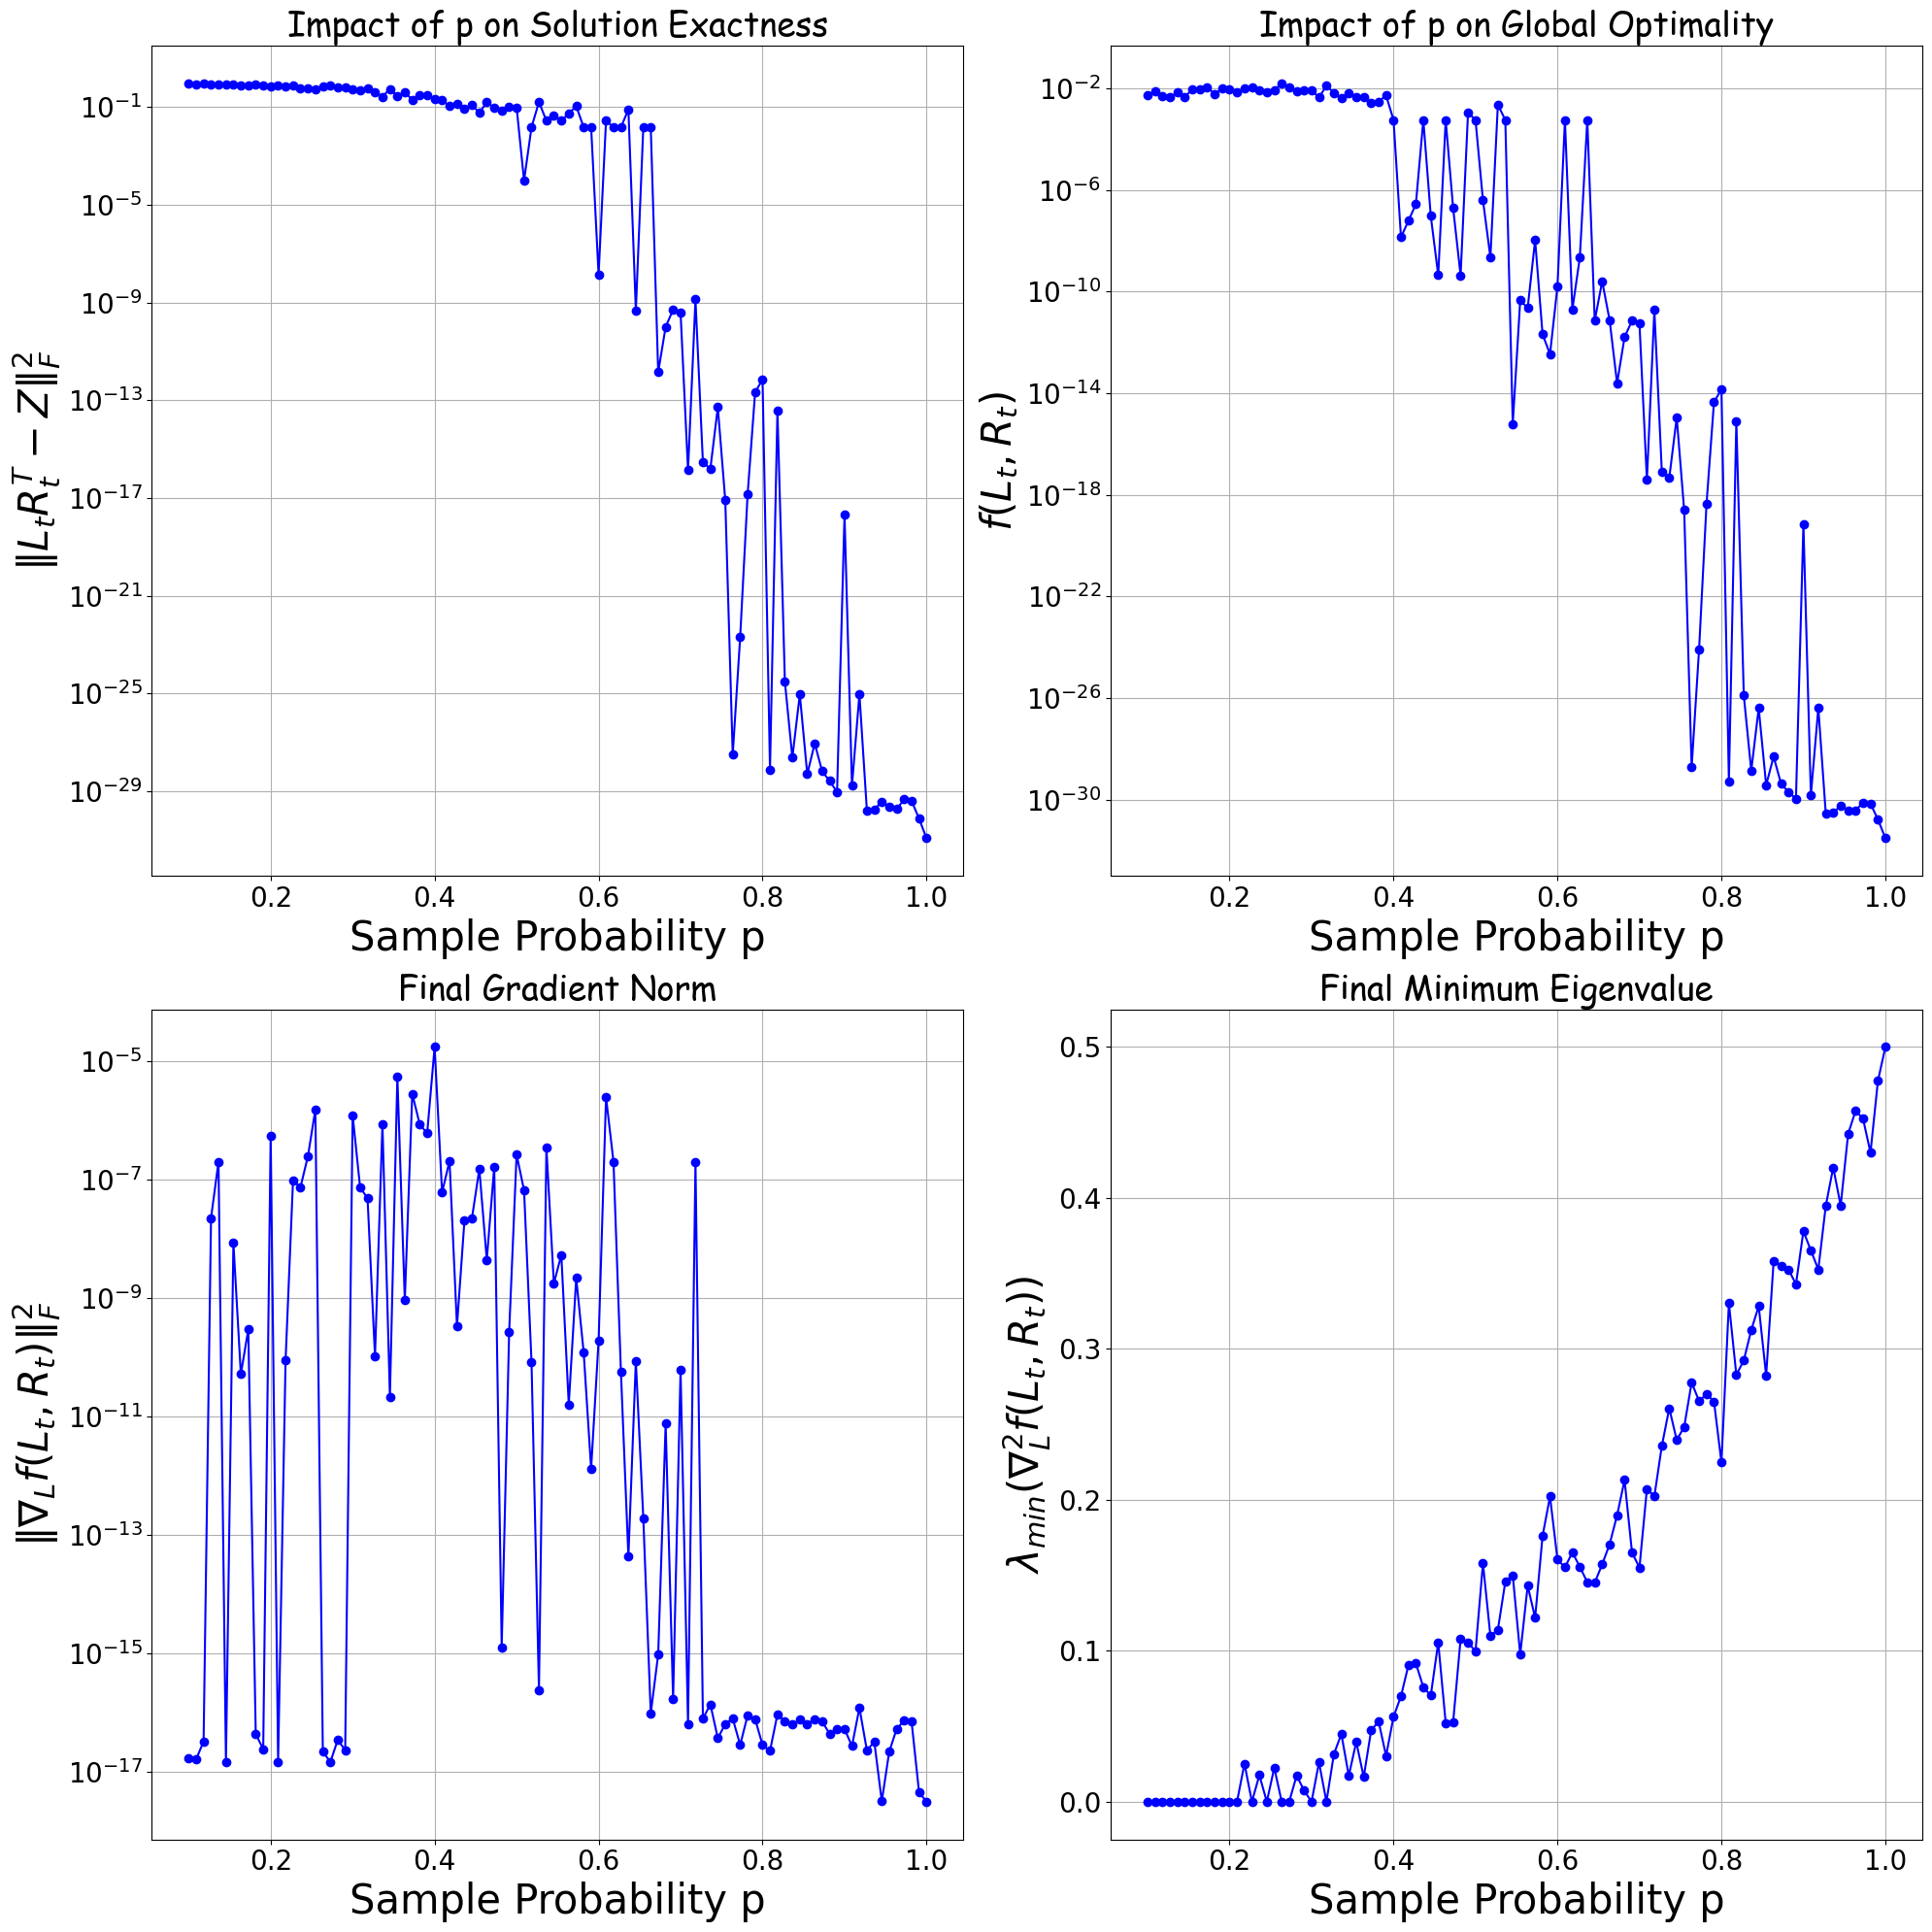

In [4]:
n   = 5
m   = 5
r   = 1
mu  = 2
PSD = True

projected = False
iters = 5000
lr = 0.01

data_points = 100
ensemble = 10
optim = 'SGD'

same_seed(0)
probs, SE, FE, GN, MEI = generate_data(n, m, r, mu, PSD, projected, optim, iters, lr, data_points, ensemble)
plot_error(probs, SE, FE, GN, MEI)